# Simple preprocessing

This guide introduces a selection of tools to preprocess the street network and eliminate unwanted gaps in the network and fix its topology.

In [1]:
import geopandas as gpd
from shapely.geometry import LineString

import neatnet

## Close gaps

The first issue which may happen is the network which is disconnected. The endpoints do not match. Such a network would result in incorrect results of any graph-based analysis. `neatnet.close_gaps` can fix the issue by snapping nearby endpoints to a midpoint between the two.

In [2]:
l1 = LineString([(1, 0), (2, 1)])
l2 = LineString([(2.1, 1), (3, 2)])
l3 = LineString([(3.1, 2), (4, 0)])
l4 = LineString([(4.1, 0), (5, 0)])
l5 = LineString([(5.1, 0), (6, 0)])

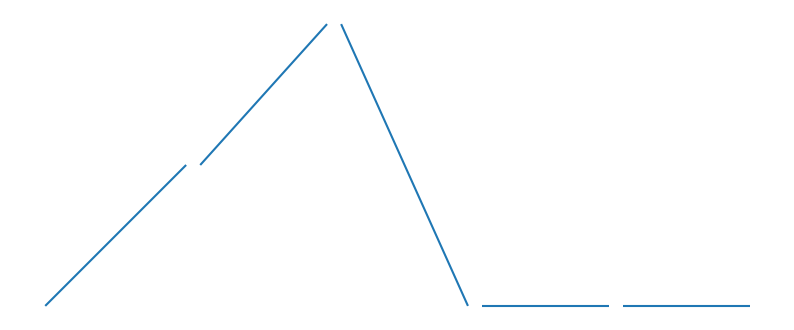

In [3]:
df = gpd.GeoDataFrame(["a", "b", "c", "d", "e"], geometry=[l1, l2, l3, l4, l5])
df.plot(figsize=(10, 10)).set_axis_off()

All LineStrings above need to be fixed.

In [4]:
df.geometry = neatnet.close_gaps(df, 0.25)

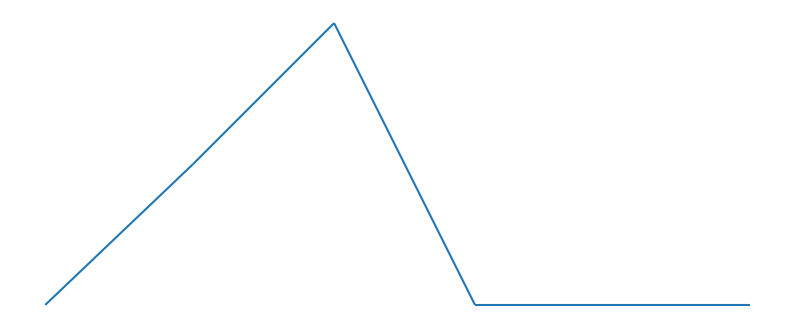

In [5]:
df.plot(figsize=(10, 10)).set_axis_off()

Now we can compare how the fixed network looks compared to the original one.

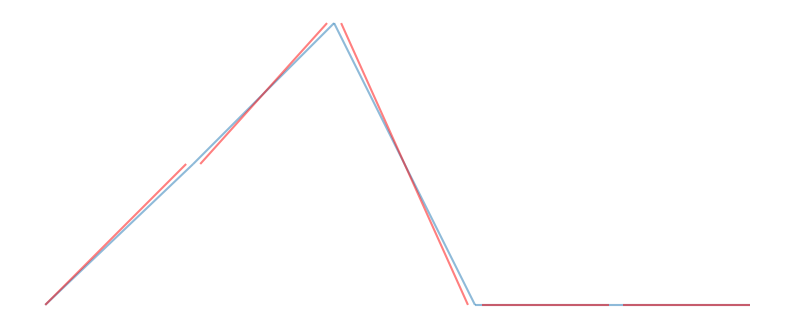

In [6]:
ax = df.plot(alpha=0.5, figsize=(10, 10))
gpd.GeoDataFrame(geometry=[l1, l2, l3, l4, l5]).plot(ax=ax, color="r", alpha=0.5)
ax.set_axis_off()

## Remove false nodes

A very common issue is incorrect topology. LineString should end either at road intersections or in dead-ends. However, we often see geometry split randomly along the way. `neatnet.remove_false_nodes` can fix that.

We will use `mapclassify.greedy` to highlight each segment.

In [7]:
from mapclassify import greedy

import momepy

In [8]:
df = gpd.read_file(momepy.datasets.get_path("tests"), layer="broken_network")

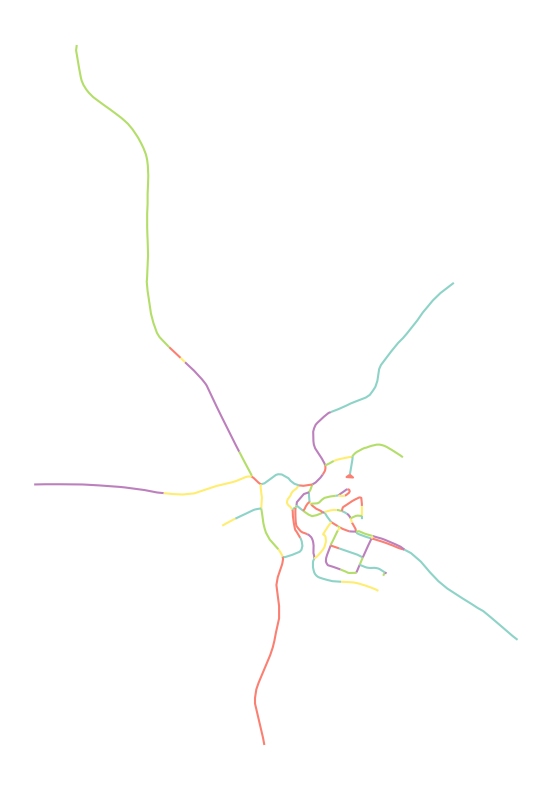

In [9]:
df.plot(greedy(df), categorical=True, figsize=(10, 10), cmap="Set3").set_axis_off()

You can see that the topology of the network above is not as it should be.

For a reference, let's check how many geometries we have now:

In [10]:
len(df)

83

Okay, 83 is a starting value. Now let's remove false nodes.

In [11]:
fixed = neatnet.remove_false_nodes(df)

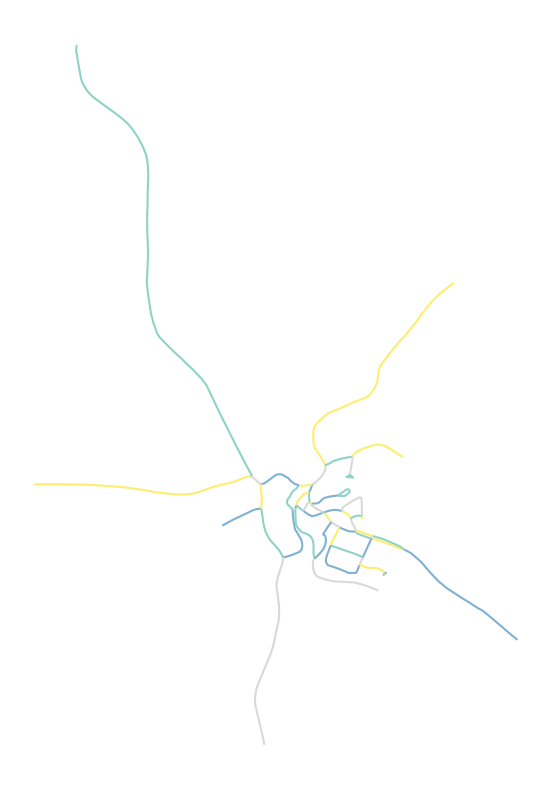

In [12]:
fixed.plot(
    greedy(fixed), categorical=True, figsize=(10, 10), cmap="Set3"
).set_axis_off()

From the figure above, it is clear that the network is now topologically correct. How many features are there now?

In [13]:
len(fixed)

56

We have been able to represent the same network using 27 features less.

## Extend lines

In some cases,  we may want to close some gaps by extending existing LineStrings until they meet other geometry.

In [14]:
l1 = LineString([(0, 0), (2, 0)])
l2 = LineString([(2.1, -1), (2.1, 1)])
l3 = LineString([(3.1, 2), (4, 0.1)])
l4 = LineString([(3.5, 0), (5, 0)])
l5 = LineString([(2.2, 0), (3.5, 1)])

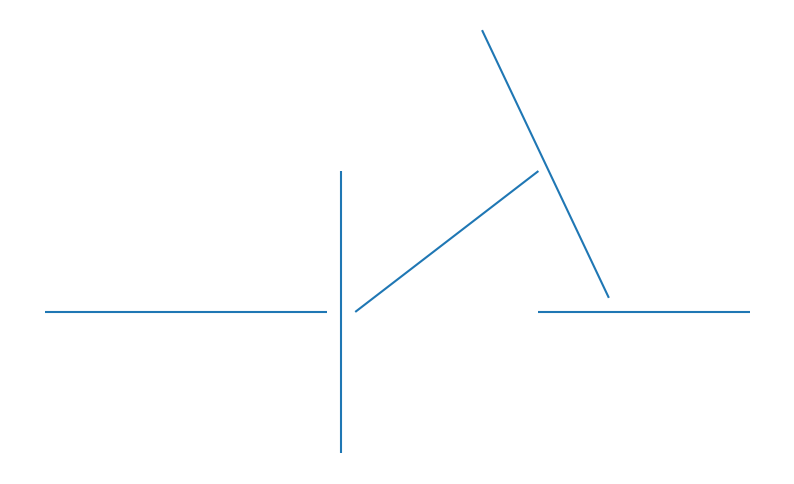

In [15]:
df = gpd.GeoDataFrame(["a", "b", "c", "d", "e"], geometry=[l1, l2, l3, l4, l5])
df.plot(figsize=(10, 10)).set_axis_off()

The situation above is typical. The network is almost connected, but there are gaps. Let's extend geometries and close them. Note that we cannot use `neatnet.close_gaps` in this situation as we are not snapping endpoints to endpoints.

In [16]:
extended = neatnet.extend_lines(df, tolerance=0.2)

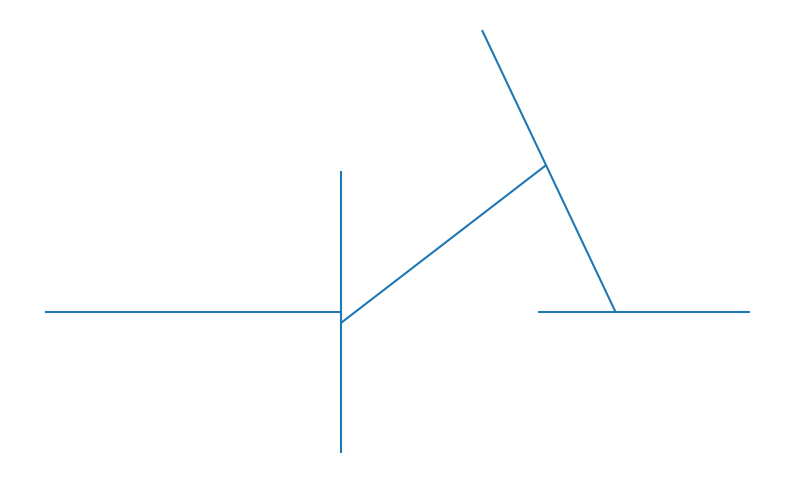

In [17]:
extended.plot(figsize=(10, 10)).set_axis_off()

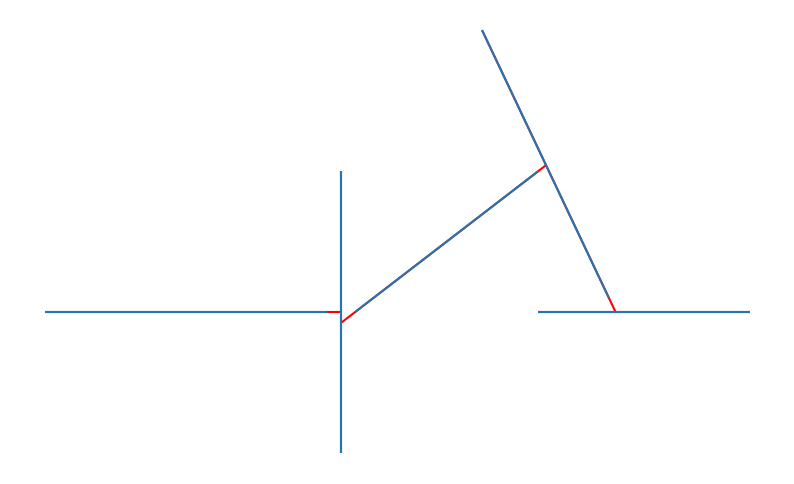

In [18]:
ax = extended.plot(figsize=(10, 10), color="r")
df.plot(ax=ax)
ax.set_axis_off()

The figures above are self-explanatory. However, remember that the extended network is not topologically correct and is not suitable for network analysis directly. Use `induce_nodes` to fix it if needed.

For more details and further options, see the [API documentation](api.rst).